In [1]:
# https://github.com/mdtraj/mdtraj/blob/master/examples/hbonds.ipynb
from __future__ import print_function
from pathlib import Path
import itertools
import mdtraj as md
#import mdtraj.testing
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
top = md.load_pdb(str( "240905_Final_topology_50ns_PME_7.pdb"))
t = md.load_xtc(str( "20240905_transformed_trajectory_rank7_2.xtc"), top=top.top)
print(t)

<mdtraj.Trajectory with 500 frames, 61201 atoms, 19327 residues, and unitcells>


In [3]:
protein = t.topology.select("protein")
ligand = t.topology.select("resname UNK")

md.baker_hubbard identifies hydrogen bonds baced on cutoffs for the Donor-H...Acceptor distance and angle. The criterion employed is and in at least 10% of the trajectory. The return value is a list of the indices of the atoms (donor, h, acceptor) that satisfy this criteria.

In [4]:
hbonds = md.baker_hubbard(t, periodic=False)
hbonds.shape

(383, 3)

In [5]:
labels = dict()
for i, hbond in enumerate(hbonds):
    if (((hbond[0] in protein) and (hbond[2] in ligand)) or # ligand is acceptor
        ((hbond[0] in ligand) and (hbond[2] in protein))): # ligand is donor
        if not (hbond[0] in ligand and hbond[2] in ligand): # don't count ligand-ligand hbonds
            print(i, t.topology.atom(hbond[0]), t.topology.atom(hbond[2]))
            labels[str(i)] = f"{t.topology.atom(hbond[0])}-{t.topology.atom(hbond[2])}"

103 CYS502-N UNK0-O1x


In [6]:
da_distance = md.compute_distances(t, hbonds[:, [0,2]], periodic=False)

In [7]:
da_distance.shape

(500, 383)

In [8]:
print(labels)

{'103': 'CYS502-N-UNK0-O1x'}


In [ ]:
# color = itertools.cycle(["r", "b"])

for i in [103]:
    plt.hist(da_distance[:, i], label=labels[str(i)], alpha=0.5, range=(0.2, 0.9), bins=50)
    print(f"{labels[str(i)]:s} bonds distance means {da_distance[:, i].mean():.2f}nm"
          f" and std {da_distance[:, i].std():.2f}nm")

plt.legend()
plt.ylabel("Count")
plt.xlim(0.2, 0.9)
plt.xlabel("Donor-acceptor distance [nm]"); # hydrogen bond distance between heavy atoms is typically < 0.30 nm
plt.savefig("20240927_distance_count_rank7.png")

CYS502-N-UNK0-O1x bonds distance means 0.29nm and std 0.01nm


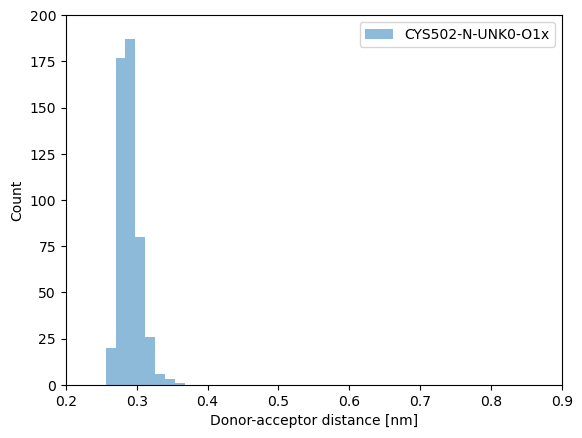

In [9]:
# color = itertools.cycle(["r", "b"])

for i in [103]:
    plt.hist(da_distance[:, i], label=labels[str(i)], alpha=0.5, range=(0.2, 0.9), bins=50)
    print(f"{labels[str(i)]:s} bonds distance means {da_distance[:, i].mean():.2f}nm"
          f" and std {da_distance[:, i].std():.2f}nm")

plt.legend()
plt.ylabel("Count")
plt.xlim(0.2, 0.9)
plt.ylim(0, 200)
plt.xlabel("Donor-acceptor distance [nm]"); # hydrogen bond distance between heavy atoms is typically < 0.30 nm
plt.savefig("20240927_distance_count_rank7_regulated_yaxis_scale.png")

In [10]:
n_frame = len(t)

In [11]:
all_hbonds_set = set()
hbonds_each_frame = []

In [12]:
Frame2hbonds = dict()
for frame in range(n_frame):
    Frame2hbonds[frame] = []
    hbonds = md.baker_hubbard(t[frame])
    hbonds_each_frame.append(hbonds)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand) or
            (hbond[0] in ligand) and (hbond[2] in protein)):
            if not (hbond[0] in ligand and hbond[2] in ligand):
                all_hbonds_set.add(tuple(hbond))
                Frame2hbonds[frame].append(tuple(hbond))

In [13]:
x = [] # frame
y = [] # number of hbonds

In [14]:
for frame in Frame2hbonds:
    x.append(frame)
    y.append(len(Frame2hbonds[frame]))

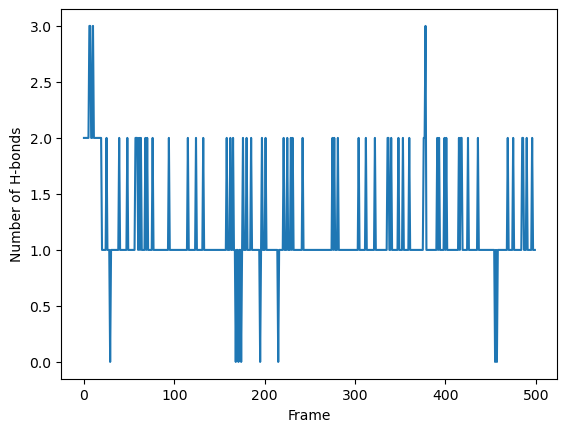

In [16]:
plt.plot(x,y)
plt.xlabel("Frame")
plt.ylabel("Number of H-bonds")
plt.savefig("20240911_hbonds_frame_rank7.png")
plt.show()

In [15]:
from matplotlib.ticker import MaxNLocator

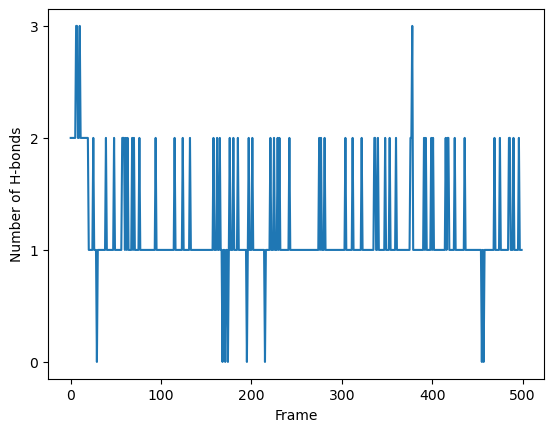

In [16]:
plt.plot(x,y)
plt.xlabel("Frame")
plt.ylabel("Number of H-bonds")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("20240927_hbonds_frame_rank7_yaxis_integer.png")
plt.show()

In [17]:
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist

In [18]:
# 103 CYS502-N UNK0-O1x

In [19]:
protein_residue_id = "502"
protein_atom_name = "N"
ligand_name = "UNK"
ligand_id = "2"
ligand_atom_name = "O1x"

In [20]:
md_universe = mda.Universe("240905_Final_topology_50ns_PME_7.pdb", "20240905_transformed_trajectory_rank7_2.xtc")

atomgroup_protin = md_universe.select_atoms(
    f"resid {protein_residue_id} and name {protein_atom_name}"
)
atomgroup_ligand = md_universe.select_atoms(f"resname {ligand_name} and name {ligand_atom_name}")

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:287: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [21]:
atomgroup_protin.atoms, atomgroup_ligand.atoms

(<AtomGroup with 1 atom>, <AtomGroup with 1 atom>)

In [22]:
distance = dist(atomgroup_protin, atomgroup_ligand)
print(
    f"The distance between residues {protein_residue_id} and {ligand_atom_name} of {ligand_name} is {distance[2][0]:.2f} Å"
)

The distance between residues 502 and O1x of UNK is 3.20 Å


In [23]:
distances = []
for _ in md_universe.trajectory:
    distance = dist(atomgroup_protin, atomgroup_ligand)
    distances.append(distance[2][0])


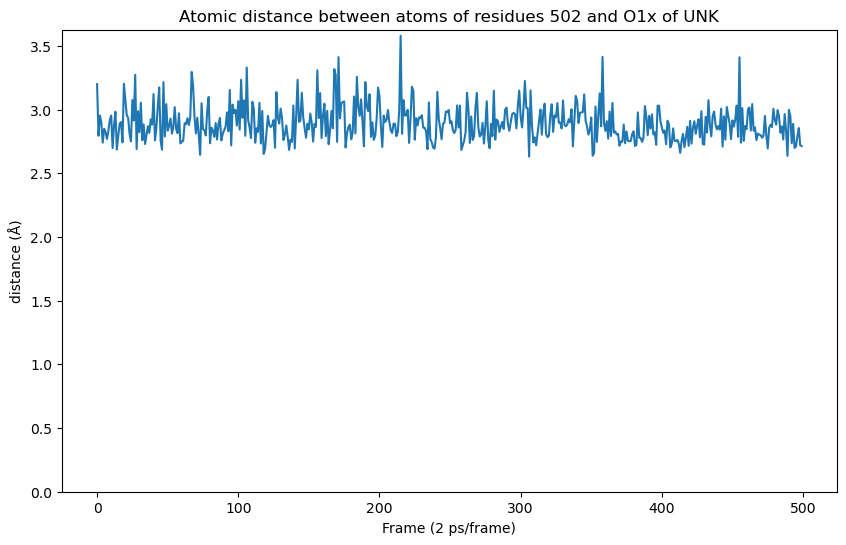

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("Frame (2 fs/frame)")
plt.title(f"Atomic distance between atoms of residues {protein_residue_id} and {ligand_atom_name} of {ligand_name}")
plt.savefig("20240911_distance_frame_rank7.png")
plt.show()